In [1]:
!pip install "gymnasium[atari, accept-rom-license]"
!pip install atari-py -U
!pip install shimmy
!pip install moviepy
#!apt-get install -y xvfb x11-utils
#!pip install pyvirtualdisplay==0.2.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 17.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=a9ecfa43384fde45d66d3af569cb7f921160d45235e07b2f23ceec06e965d665
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for atari-py: filename=atari_py-0.2.9-cp310-cp310-linux_x86_64.whl size=2868439 sha256=55e6d4893f1c8e9b3038a4038bc8c4cab1a0416710b5c50991560b63d6a60ae3
  Stored in dir

In [2]:
import gymnasium as gym
import ale_py
import shimmy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.distributions import Categorical
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import ale_py
import os
warnings.filterwarnings("ignore")

In [3]:
def out_size(input_size, kernel_size = 3, padding = 1, stride = 2):
    return (input_size - kernel_size + 2 * padding) // stride + 1

In [4]:
class Policy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Policy, self).__init__()
        self.inp = nn.Linear(input_dim, 32)
        self.out = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.inp(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.softmax(x)
        return x
    
class CNNPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNPolicy, self).__init__()
        self.inp = torch.nn.Conv2d(input_dim[2], 3, 3, stride=1, padding=1)
        self.conv = nn.Sequential(
            torch.nn.Conv2d(3, 3, 3, stride=1, padding=1),
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1),
            torch.nn.Conv2d(3, 1, 3, stride=2, padding=1),
        )
        self.flatten = nn.Flatten()
        s = (out_size(input_dim[0]), out_size(input_dim[1]))
        s2 = (out_size(s[0]), out_size(s[1]))
        self.out = nn.Linear(s2[0] * s2[1], output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.inp(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.out(x)
        x = self.softmax(x)
        return x

In [5]:
CNNPolicy((250, 160, 3), 3)

CNNPolicy(
  (inp): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(3, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=2520, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [6]:
class Value(nn.Module):
    def __init__(self, input_dim):
        super(Value, self).__init__()
        self.inp = nn.Linear(input_dim, 32)
        self.out = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.inp(x)
        x = self.relu(x)
        x = self.out(x)
        return x
    
class CNNValue(nn.Module):
    def __init__(self, input_dim):
        super(CNNValue, self).__init__()
        self.inp = torch.nn.Conv2d(input_dim[2], 3, 3, stride=1, padding=1)
        self.conv = torch.nn.Conv2d(3, 1, 3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.out = nn.Linear(input_dim[0] * input_dim[1], 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.inp(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.out(x)
        x = self.softmax(x)
        return x

In [7]:
class PPO:
    def __init__(self, policy, value, env, num_epochs=20, max_steps=1000, epsilon=0.2, optimization_steps=4, gamma=0.99, lr=0.001, device = 'cpu'):
        self.policy = policy
        self.value = value
        self.env = env
        self.num_epochs = num_epochs
        self.max_steps = max_steps
        self.epsilon = epsilon
        self.optimization_steps = optimization_steps
        self.gamma = gamma
        self.lr = lr
        self.device = device
        self.total_rewards = []
        
        
    def calculate_returns(self, rewards, gamma):
        returns = []
        discounted_reward = 0
        for r in reversed(rewards):
            discounted_reward = r + gamma * discounted_reward
            returns.append(discounted_reward)
        return returns[::-1]
    
    def calculate_advantages(self, returns, values):
        return torch.Tensor(returns) - torch.Tensor(values)
        
    def train(self, schedule = [[100, 0.001]], show_rewards = False):
        self.total_rewards = []
        policy_optimizer = optim.Adam(self.policy.parameters(), lr = self.lr)
        value_optimizer = optim.Adam(self.value.parameters(), lr = self.lr)
        
        mse_loss = nn.MSELoss()
        for num_epochs, lr in schedule:
            self.lr = lr
            self.num_epochs = num_epochs
            for g in policy_optimizer.param_groups:
                g['lr'] = self.lr
            for g in value_optimizer.param_groups:
                g['lr'] = self.lr
            for epoch in tqdm(range(self.num_epochs), desc = f"Training [lr = {self.lr}]", unit = " epochs"):
                states = []
                actions = []
                rewards = []
                old_logprobs = []
                values = []
                advantages = []
                returns = []
                total_rewards = 0

                state, _ = env.reset()

                for step in range(self.max_steps):
                    state = torch.FloatTensor(state).unsqueeze(0)
                    action_probs = self.policy(state.to(self.device)).cpu()
                    dist = Categorical(action_probs)
                    action = dist.sample()
                    logprob = dist.log_prob(action)
                    value_estimate = self.value(state.to(self.device)).cpu()

                    next_state, reward, terminated, truncated, info = env.step(action.item())

                    states.append(torch.Tensor(state).squeeze(0))
                    actions.append(action)
                    rewards.append(reward)
                    old_logprobs.append(logprob)
                    values.append(value_estimate)

                    total_rewards += reward
                    state = next_state

                    if terminated or truncated:
                        break

                returns = self.calculate_returns(rewards, self.gamma)
                advantages = self.calculate_advantages(returns, values)

                states = torch.stack(states).detach()
                actions = torch.Tensor(actions).detach()
                old_logprobs = torch.Tensor(old_logprobs).detach()
                returns = torch.Tensor(returns).detach()
                advantages = torch.Tensor(advantages).detach()

                for _ in range(self.optimization_steps):
                    action_probs = self.policy(states.to(self.device)).cpu()
                    dist = Categorical(action_probs)
                    logprob = dist.log_prob(actions)

                    ratio = torch.exp(logprob - old_logprobs)

                    surr1 = ratio * advantages
                    surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages

                    policy_loss = -torch.min(surr1, surr2)

                    policy_optimizer.zero_grad()
                    policy_loss.mean().backward()
                    policy_optimizer.step()

                    value_estimate = self.value(states.to(self.device)).cpu()
                    value_loss = mse_loss(value_estimate, returns)

                    value_optimizer.zero_grad()
                    value_loss.mean().backward()
                    value_optimizer.step()

                self.total_rewards.append(total_rewards)
                if(show_rewards):
                    print('Epoch [{}/{}], Total Reward: {:.2f}'.format(epoch + 1, self.num_epochs, total_rewards))
    def plot(self):
        plt.plot(pd.DataFrame({'rewards': self.total_rewards}).rolling(10).mean(), alpha = 0.8, linewidth = 4)
        plt.title("Reward over training")
        plt.xlabel("Epoch")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()
    def video(self, env):
        recorder = VideoRecorder(env, 'video.mp4')
        state, _ = env.reset()
        for step in range(self.max_steps):
            state = torch.FloatTensor(state).unsqueeze(0)
            action_probs = self.policy(state.to(self.device)).cpu()
            dist = Categorical(action_probs)
            action = dist.sample()
            logprob = dist.log_prob(action)
            value_estimate = self.value(state.to(self.device)).cpu()

            state, reward, terminated, truncated, info = env.step(action.item())
            recorder.capture_frame()
            if terminated or truncated:
                break
        recorder.close()
        
    def save(self, path = "./"):
        torch.save(self.policy.state_dict(), os.path.join(path, "policy.pt"))
        torch.save(self.value.state_dict(), os.path.join(path, "value.pt"))
    def load(self, path = "./"):
        self.policy.load_state_dict(torch.load(os.path.join(path, "policy.pt")))
        self.value.load_state_dict(torch.load(os.path.join(path, "value.pt")))

Training [lr = 0.01]:   0%|          | 0/20 [00:00<?, ? epochs/s]

Training [lr = 0.001]:   0%|          | 0/100 [00:00<?, ? epochs/s]

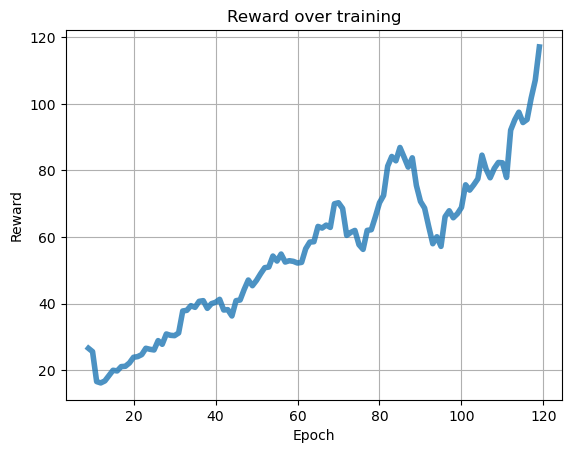

In [8]:
env = gym.make('CartPole-v0')
policyNN = Policy(4, 2)
valueNN = Value(4)
ppo = PPO(policyNN, valueNN, env)
schedule = [
    (20, 0.01),
    (100, 0.001),
]

ppo.train(schedule)
ppo.plot()

In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# env = gym.make('ALE/AirRaid-v5')
# policyNN = CNNPolicy(env.observation_space.shape, 6)
# policyNN.to(device)
# valueNN = CNNValue(env.observation_space.shape)
# valueNN.to(device)
# ppo = PPO(policyNN, valueNN, env, device = device)
# schedule = [
#     (20, 0.001),
#     (80, 0.0005),
# ]
# ppo.train(schedule = schedule, show_rewards = True)
# ppo.plot()
# ppo.save()